In [4]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd

In [5]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [15]:
shp_f = './ground_data/April2021/AllColoniesMerged_forAHPIS/PdogPostPoly_Merge.shp'
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [7]:
cper = gpd.read_file(cper_f)

<AxesSubplot:>

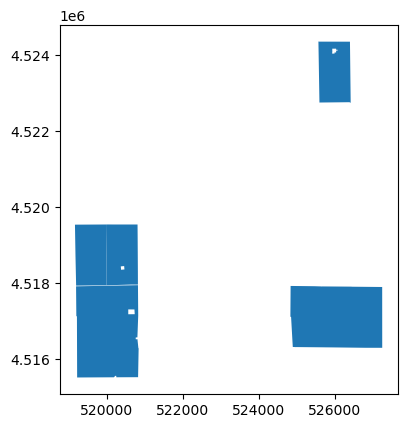

In [8]:
cper.plot()

In [9]:
cell_size = 5.0
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry, cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)

In [10]:
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))

In [11]:
cper_xr = cper_xr.where(cper_xr != 0)

In [16]:
gdf_yr = gpd.read_file(shp_f)
gdf_yr = gdf_yr.to_crs(32613)
yr_xr = shp2mask(gdf_yr.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape)

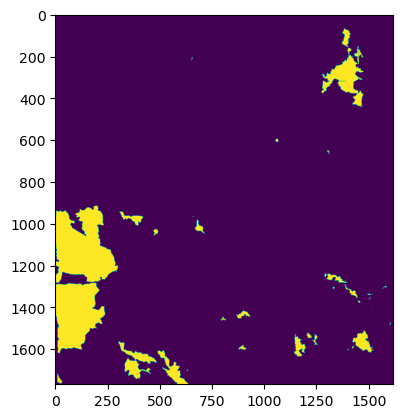

<AxesSubplot:>

In [19]:
from rasterio.plot import show
show(yr_xr.data)

In [20]:
yr_xr.where(cper_xr.notnull()).rio.to_raster('./ground_data/April2021/AllColoniesMerged_forAHPIS/April2021_binary.tif')

In [21]:
df_past = cper_xr.to_dataframe(name='Pasture')
df_yr = yr_xr.to_dataframe(name='yr_active')

In [22]:
df_out = pd.merge(df_past, df_yr, left_index=True, right_index=True)
df_out = df_out[df_out['Pasture'].notnull()].copy()

In [23]:
past_name_dict = {}
for i in df_out['Pasture'].unique():
    past_name_dict[i] = cper['Past_Name_'][cper['OBJECTID'] == i].values[0]

In [24]:
df_out['Pasture'] = df_out['Pasture'].map(past_name_dict)
df_out.loc[df_out['Pasture'].isin(['22W', '22E']), 'Pasture'] = '22EW'

In [25]:
df_out_smry = df_out.groupby('Pasture').sum() * (5**2 * 1e-4)

In [26]:
df_out_smry = df_out_smry.reset_index().rename(columns={'yr_active': 'ha_obs_2020'})

In [27]:
df_out_smry

,Pasture,ha_obs_2020
0,22EW,169.0125
1,29-30,23.5325
2,5W,36.9975
3,CN,141.9475


In [28]:
if not os.path.exists('./ground_data/historical/summaries/'):
    os.mkdir('./ground_data/historical/summaries/')

In [30]:
df_out_smry.to_csv('./ground_data/historical/summaries/pDog_2021_April_summary.csv', index=False)